### Structure factor
\begin{equation}
S(q) = \frac{1}{N}\sum_{ij} \langle S_{i}.S_{j} \rangle e^{\iota q |i-j|}
\end{equation}
$\langle S_{i}.S_{j}\rangle$ is the monte carlo average of the spin-spin correlation function.
* The expression can be simplified for a three dimensional vector with component $s_{x},s_{y},s_{z}$ as,
\begin{equation}
\langle S_{i}.S_{j}\rangle =  \langle S_{i,x}S_{j,x} + S_{i,y}S_{j,y} + S_{i,z}S_{y,z}\rangle
\end{equation} 
* The monte carlo averaged quantity can be calculated as,
\begin{equation}
\langle S_{i,k}S_{j,k}\rangle  = \frac{1}{M} \sum_{p=1}^{M} S^{(p)}_{i,k} S^{(p)}_{j,k}
\end{equation}
* Here $p$ is the sum over the different monte-carlo configurations. 
* The sum is performed for all the spin components.

In [232]:
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [278]:
### class to initialize the variables and functions one need to calculate the structure factor
class StructureFactor:
    def __init__(self,L):
        ''' 
        This will instantiate an object of type structure factor.
            Parameters:
                L(int): system size
            return :
                L(int) : system size
                n_sites(int) : number of sites in the system
        '''

        self.L = L
        self.n_sites = self.L ** 2

    ### function to get the names of file we are interested in 
    def getFile(self):
        ''' 
            this function will get all the files inside the folder that we need
            Parameters:
                object instance: (self)
            
            return :
                dictfile: dictionary containing names of all the files with keys as the temperature values.
        '''
        ### store names of all files inside the folder
        f = os.listdir()
        
        ## file names that we need for calculations also the temperature values
        f_list,temp_list = [],[]
        
        ## loop over all the files in the folder
        for j in f:
            ## choose only files that starts with configurations
            if j.startswith('configurations'):
                ## obtain the temperature from the file name
                temp=j.split('temp')[1].split('_Uint2')[0]
                ## append the file name
                f_list.append(j)
                ## append the temperature value
                temp_list.append(float(temp))
       
        self.filedict = dict(sorted(dict(zip(temp_list,f_list)).items()))
        

    ## function to load one file. The temperature (key is supplied as an argument)
    
    def loadData(self,ki):
        '''
        This function will load data and puts it in a form that is convenien
        for further use. The file that is to loaded is specified using a temperature
        that is supplied via the user.
            parameters:
                self(instance): Object that is to be used
                ki(key): the key that will be used to load the corresponding file
            return
                df (dataframe): dataframe containing the data of the file 
                    that is loaded
        '''

        tempf = pd.read_csv(self.filedict[ki],header=None,sep='\t')
        tempf.columns = ['data']
        m,theta,phi,temp_i = [],[],[],[]
        for j in range(tempf.shape[0]):
            _,_,m1,m2,m3 = tempf.iloc[j,0].split()
            #print(f'm: {m1} theta: {m2} phi: {m3}')
            m.append(m1)
            theta.append(m2)
            phi.append(m3)
            temp_i.append(ki)
        
        m = np.array(m,dtype='float64')
        theta = np.array(theta,dtype='float64')
        phi = np.array(phi,dtype='float64')
        temp_i = np.array(temp_i)
        temp_df = pd.DataFrame({'temp':temp_i,'m':m, \
                'theta':theta,'phi':phi})

        self.df = temp_df


    ### convert m,theta,phi data frame into one with component mx,my,mz
    def calc_comp(self):
        '''
        this function will convert the dataframe with m,theta,phi 
        value into a three component vector mx,my,mz.
            parameter:
                self (instance): instance of the class
            return:
                compdf (dataframe): dataframe with the mx,my,mz component of the vector.
        '''
        ## list to store the values of mx,my,mz and temperature
        tempmx,tempmy,tempmz,temp_i = [],[],[],[]

        ## loop over all the entried of the dataframe
        for j in range(self.df.shape[0]):

            temp_i.append(self.df.iloc[j,0])
            m = self.df.iloc[j,1]
            theta = self.df.iloc[j,2]
            phi = self.df.iloc[j,3]
            #print(f'm: {m} theta: {theta} phi: {phi}')

            ### calculating component mx,my,mz using m,theta,phi
            tempmx.append(m*np.cos(phi)*np.sin(theta))
            tempmy.append(m*np.sin(phi)*np.sin(theta))
            tempmz.append(m*np.cos(theta))
        
        temp_i = np.array(temp_i)
        tempmx = np.array(tempmx)
        tempmy = np.array(tempmy)
        tempmz = np.array(tempmz)

        temp_df = pd.DataFrame({'temp':temp_i,'mx':tempmx,'my':tempmy,'mz':tempmz})
        
        self.compdf = temp_df

    ## get the x,y coordinate of the sites in the lattice as well as divide them into
    ## a sublattice
    def lattind(self):
        '''
        This function will calculate the x and y index of each site in the lattice also
        this will calculate and put the sites into either sublattice 1 or sublattice 2
            parameter:
                self(object): instance of the class
            return:
                xind(array): array of x indices of all the sites
                yind(array): array of all y indices
                asublatt(array): array that stores sites in  sublattice A
                bsublatt(array): array that stores sites in sublattice B
        '''
        ## list to store x,y indices and A and B sublattice sites
        tempx,tempy,tempA,tempB = [],[],[],[]
        for i in range(self.n_sites):
            xi,yi = i %self.L,i//self.L
            tempx.append(xi)
            tempy.append(yi)
            if ((xi+yi)%2 == 0):
                tempA.append(i)
            elif((xi+yi)%2 !=0):
                tempB.append(i)
        self.xind = np.array(tempx)
        self.yind = np.array(tempy)
        self.asublatt = np.array(tempA)
        self.bsublatt = np.array(tempB)
        



In [279]:

L = 8
## create an instance of the class structure factor
sf = StructureFactor(L)
sf.lattind()
## calling the function to get the names of the file
sf.getFile()

#sf.filedict
## load data for temp = 0.01
sf.loadData(0.01)

print(sf.df.head())

### calcualte each component
sf.calc_comp()

print(sf.compdf.head())



   temp         m     theta       phi
0  0.01  0.553258  1.553594  5.391636
1  0.01  0.407364  0.981428  1.762333
2  0.01  0.247694  1.526686  6.254737
3  0.01  0.248480  1.311767  2.504248
4  0.01  0.559885  1.537777  5.038006
   temp        mx        my        mz
0  0.01  0.347510 -0.430397  0.009517
1  0.01 -0.064466  0.332446  0.226428
2  0.01  0.247353 -0.007039  0.010922
3  0.01 -0.193036  0.142928  0.063646
4  0.01  0.179006 -0.530176  0.018484


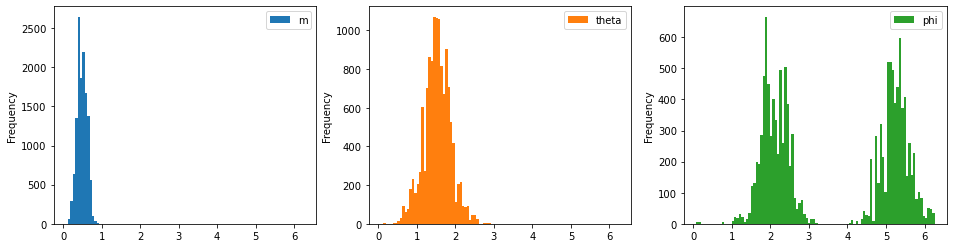

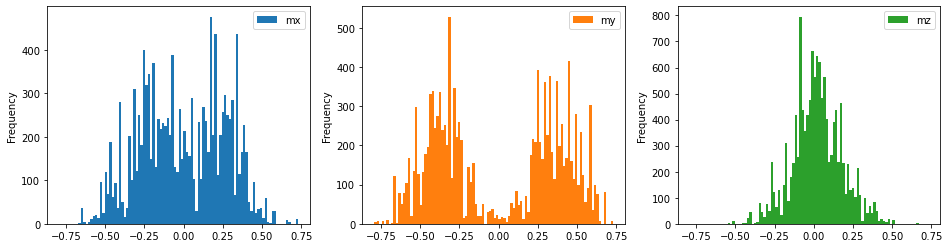

In [280]:
ax = sf.df.iloc[:,1:].plot(kind='hist',bins=100,subplots=True, \
    layout=(1,3),figsize=(16,4))
plt.show()

ax = sf.compdf.iloc[:,1:].plot(kind='hist',bins=100,subplots=True, \
    layout=(1,3),figsize=(16,4))
plt.show()


In [257]:
df_m,df_comp = pd.DataFrame(),pd.DataFrame()
loopobj = StructureFactor(8)
loopobj.getFile()
for j in loopobj.filedict.keys():
    loopobj.loadData(j)
    loopobj.calc_comp()
    df_comp  = pd.concat([df_comp,loopobj.compdf])
    df_m = pd.concat([df_m,loopobj.df])


In [274]:
def plotpx(data,col1,col2,col3,col4):
    fig = px.scatter_3d(data,x=col1,y=col2,z=col3,color=col4,size=col4)
    fig.show()

def boxplot(data,col1,col2):
    fig = sns.catplot(x=col1,y=col2,data=data,kind='boxen',height=5,aspect=2)
    plt.show()

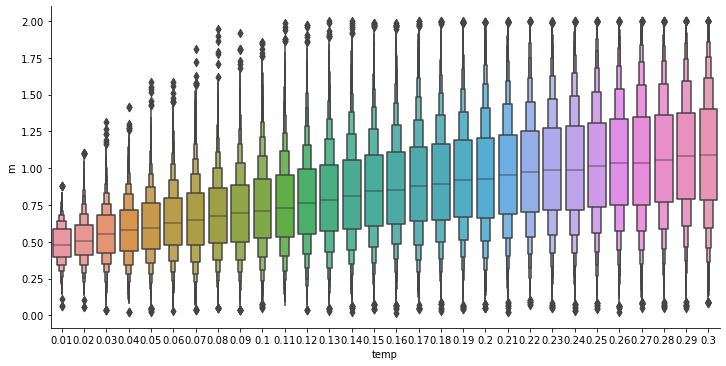

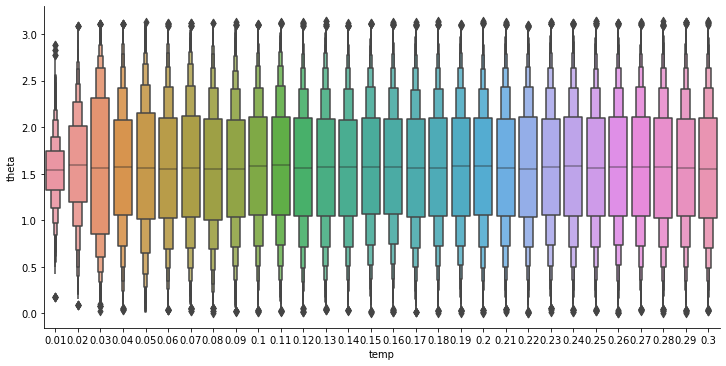

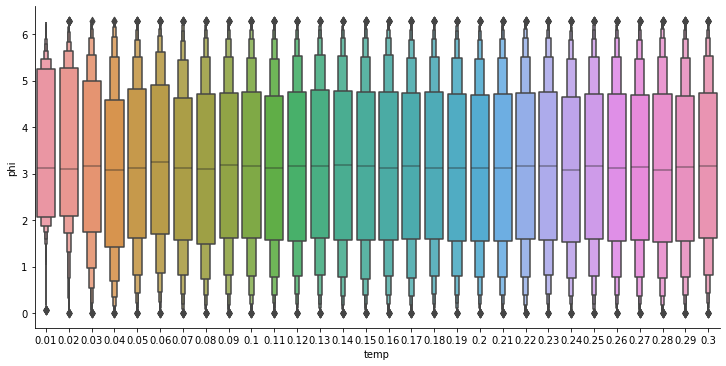

In [276]:
boxplot(df_m,'temp','m')
boxplot(df_m,'temp','theta')
boxplot(df_m,'temp','phi')

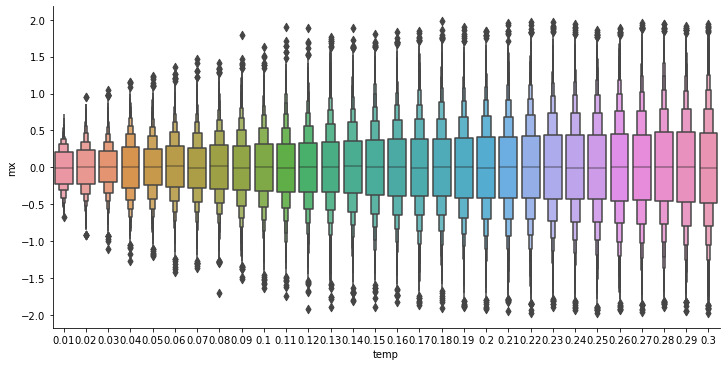

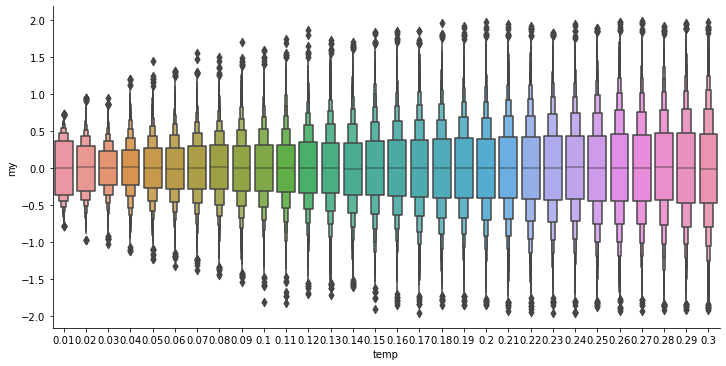

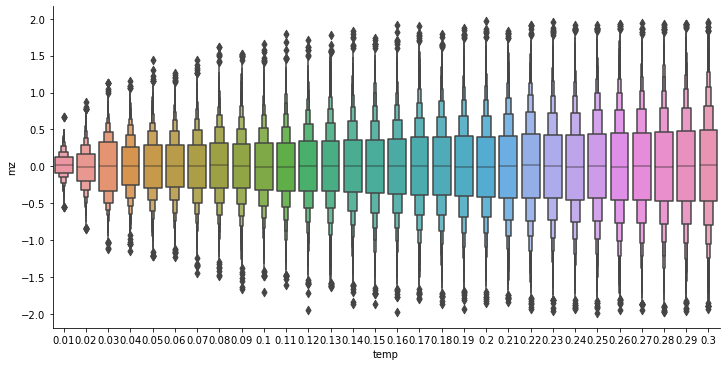

In [277]:
boxplot(df_comp,'temp','mx')
boxplot(df_comp,'temp','my')
boxplot(df_comp,'temp','mz')